The aim of this notebook is to show that a light ViT pretrained on ImageNet is able to accurately identify semantically related
crops across multiple images.

The notebook uses the term "superpatch" - it's a group of patches considered as a
crop that could be used for self-supervised learning.

# Imports & constants

In [ ]:
# TODO: review code

In [1]:
import random

from pathlib import Path

import numpy as np
import PIL
import cv2
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import timm

from torch import nn
from torch.utils.data import Dataset


In [77]:
MODEL = 'vit_tiny_patch16_224.augreg_in21k'
PATCH_SIZE = 16

N_SUPERPATCHES_TO_SAMPLE = 4  # How many superpatches to sample for visualization
N_TOP_SIMILAR = 6  # How many most similar superpatches to show per sampled superpatch

# Pick dataset

One can run the notebook on of the following datasets (just pick one subsection).

### Tiny ImageNet

https://www.kaggle.com/datasets/nikhilshingadiya/tinyimagenet200

In [20]:
# Input dims
IMG_HEIGHT = 64
IMG_WIDTH = 64

# N_AGG x N_AGG patches are grouped and constitute a superpatch
N_AGG = 2

DATA_DIR = '../data/tiny-imagenet-200'
CLS = [
    'n02793495',
    'n02963159'
]
N_SAMPLES_PER_CLS = 8

In [21]:
paths = []
for cls in CLS:
    paths_cls = list(Path(f'{DATA_DIR}/train/{cls}').rglob('*'))
    random.shuffle(paths_cls)
    paths.extend(paths_cls[:N_SAMPLES_PER_CLS])

### ImageNette

https://github.com/fastai/imagenette

In [41]:
# Input dims
IMG_HEIGHT = 256
IMG_WIDTH = 256

# N_AGG x N_AGG patches consitute superpatch
N_AGG = 8

DATA_DIR = '../data/imagenette2'
CLS = [
    'n02102040',
    'n02979186'
]
N_SAMPLES_PER_CLS = 8

In [42]:
paths = []
for cls in CLS:
    paths_cls = list(Path(f'{DATA_DIR}/train/{cls}').rglob('*'))
    random.shuffle(paths_cls)
    paths.extend(paths_cls[:N_SAMPLES_PER_CLS])

### COCO

https://cocodataset.org/#explore

In [59]:
# Input dims
IMG_HEIGHT = 384
IMG_WIDTH = 512

# N_AGG x N_AGG patches consitute superpatch
N_AGG = 8

DATA_DIR = '../data/coco'
N_SAMPLES = 8

In [60]:
paths = list(Path(DATA_DIR).rglob('*'))

# Asserts

In [61]:
assert IMG_HEIGHT % PATCH_SIZE == 0
assert IMG_WIDTH % PATCH_SIZE == 0
assert IMG_HEIGHT % (N_AGG*PATCH_SIZE) == 0
assert IMG_WIDTH % (N_AGG*PATCH_SIZE) == 0

# Load data

In [62]:
class ImgsDataset(Dataset):
  def __init__(self, paths, transform_for_nn, transform_for_display):
    self.paths = paths
    self.transform_for_nn = transform_for_nn
    self.transform_for_display = transform_for_display

  def __getitem__(self, index):
    img = PIL.Image.open(self.paths[index])

    return self.transform_for_nn(img), self.transform_for_display(img)

  def __len__(self):
    return len(self.paths)

In [63]:
transform_for_nn = [
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
]
transform_for_display = [
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH))
]

In [64]:
# Skip single-channel (grayscale) images
paths = [path for path in paths if np.asarray(PIL.Image.open(path)).shape[-1] == 3]

In [65]:
ds = ImgsDataset(
    paths,
    transforms.Compose(transform_for_nn),
    transforms.Compose(transform_for_display)
)

In [66]:
batch, imgs_orig = list(zip(*[ds[i] for i in range(len(ds))]))
batch = torch.stack(batch)
imgs_orig = [np.asarray(img) for img in imgs_orig]

# Load model

In [67]:
timm.list_models('vit_tiny_*', pretrained=True)

['vit_tiny_patch16_224.augreg_in21k',
 'vit_tiny_patch16_224.augreg_in21k_ft_in1k',
 'vit_tiny_patch16_384.augreg_in21k_ft_in1k',
 'vit_tiny_r_s16_p8_224.augreg_in21k',
 'vit_tiny_r_s16_p8_224.augreg_in21k_ft_in1k',
 'vit_tiny_r_s16_p8_384.augreg_in21k_ft_in1k']

In [68]:
model = timm.create_model(
    MODEL, 
    pretrained=True,
    img_size=(IMG_HEIGHT, IMG_WIDTH),
    num_classes=0,
    global_pool=''
)

# Visualize most similar vectors

In [69]:
vectors = model(batch)[:, 1:, :]  # Skip [CLS] token

vectors.shape

torch.Size([8, 768, 192])

In [70]:
# (B, H*W, C) -> (B, H, W, C)
vectors = vectors.view(
    vectors.shape[0], IMG_HEIGHT//PATCH_SIZE, IMG_WIDTH//PATCH_SIZE, vectors.shape[2]
)
vectors = vectors.permute(0, 3, 1, 2)  # (B, H, W, C) -> (B, C, H, W)
vectors = nn.AvgPool2d(N_AGG, count_include_pad=False)(vectors)

vectors.shape

torch.Size([8, 192, 3, 4])

In [71]:
vectors = vectors.permute(0, 2, 3, 1)  # (B, C, H, W) -> (B, H, W, C)
vectors = vectors.flatten(0, 2)  # (B, H, W, C) -> (B*H*W, C)

vectors.shape

torch.Size([96, 192])

In [72]:
def get_similarities(a, b, eps=1e-8):
    norm_a, norm_b = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]

    a_norm = a / torch.max(norm_a, eps * torch.ones_like(norm_a))
    b_norm = b / torch.max(norm_b, eps * torch.ones_like(norm_b))

    similarities = torch.mm(a_norm, b_norm.transpose(0, 1))

    return similarities

In [73]:
similarities = get_similarities(vectors, vectors)

In [74]:
def overlay_superpatch_by_index(superpatch_idx):
    n_superpatch_cols_per_img = IMG_WIDTH // PATCH_SIZE // N_AGG
    n_superpatch_rows_per_img = IMG_HEIGHT // PATCH_SIZE // N_AGG
    n_superpatchs_per_img = n_superpatch_cols_per_img * n_superpatch_rows_per_img

    img_idx = superpatch_idx // n_superpatchs_per_img
    local_superpatch_idx = superpatch_idx % n_superpatchs_per_img
    superpatch_row_idx = local_superpatch_idx // n_superpatch_cols_per_img
    superpatch_col_idx = local_superpatch_idx % n_superpatch_cols_per_img

    y_upper = superpatch_row_idx * PATCH_SIZE * N_AGG
    x_upper = superpatch_col_idx * PATCH_SIZE * N_AGG
    y_lower = (superpatch_row_idx+1) * PATCH_SIZE * N_AGG
    x_lower = (superpatch_col_idx+1) * PATCH_SIZE * N_AGG

    img_w_crop = np.copy(imgs_orig[img_idx])
    cv2.rectangle(
        img_w_crop, 
        (x_upper, y_upper), 
        (x_lower, y_lower),
        (0, 255, 0)
    )

    return img_w_crop

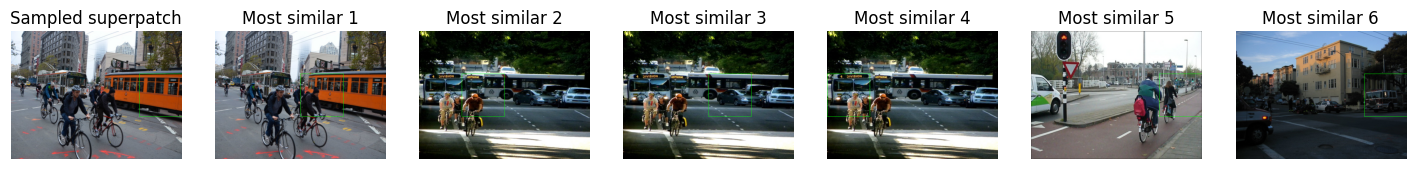

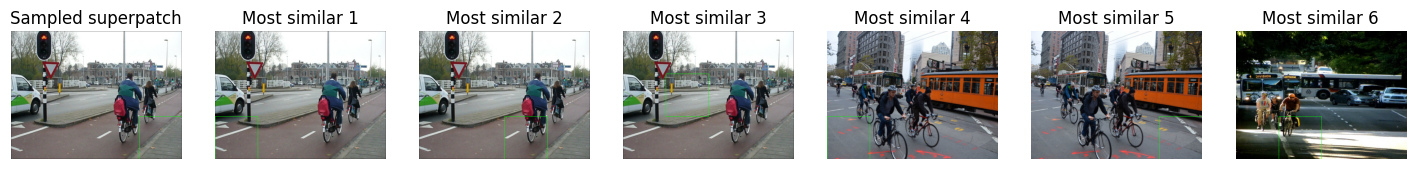

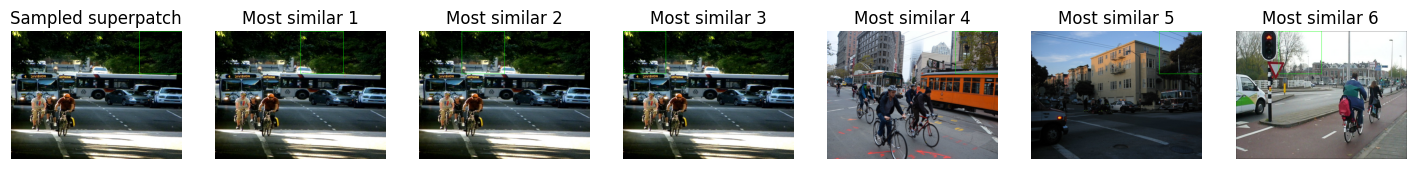

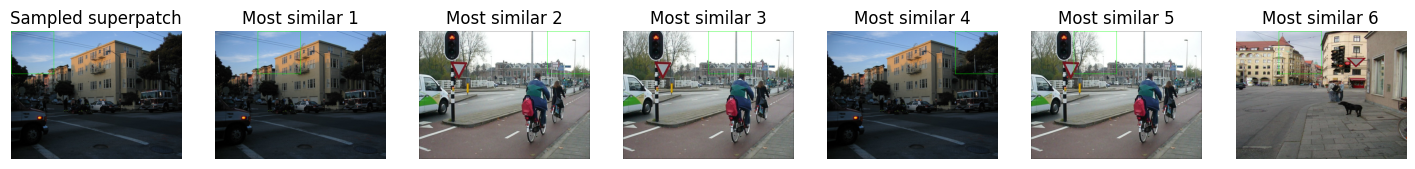

In [78]:
superpatch_idxs = random.sample(range(vectors.shape[0]), N_SUPERPATCHES_TO_SAMPLE)

for superpatch_idx in superpatch_idxs:
    top_similar = torch.argsort(
        similarities[superpatch_idx], 
        descending=True
    ).numpy()[1:]  # Skip identical crop

    fig, axs = plt.subplots(
        1, N_TOP_SIMILAR+1, figsize=(N_TOP_SIMILAR*3, 5)
    )
    for ax in axs:
        ax.axis('off')
        
    axs[0].imshow(overlay_superpatch_by_index(superpatch_idx))
    axs[0].set_title('Sampled superpatch')
    for i in range(N_TOP_SIMILAR):
        axs[i+1].imshow(overlay_superpatch_by_index(top_similar[i]))
        axs[i+1].set_title(f'Most similar {i+1}')
    plt.show()
    plt.close()